## Loading libraries

In [1]:
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler 

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc, SCORERS,  ConfusionMatrixDisplay
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import set_config
set_config(display ="diagram")

import warnings
#warnings.filterwarnings(action='ignore', category=UserWarning)
#warnings.filterwarnings(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

from datetime import datetime
import os
#import shutil

import matplotlib.pyplot as plt
%matplotlib inline


## Mapping Google Drive (optional)

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/Audio/notebooks

## Loading Data

In [3]:

df=pd.read_csv('../../features/features.csv')
df.shape


(23225, 30)

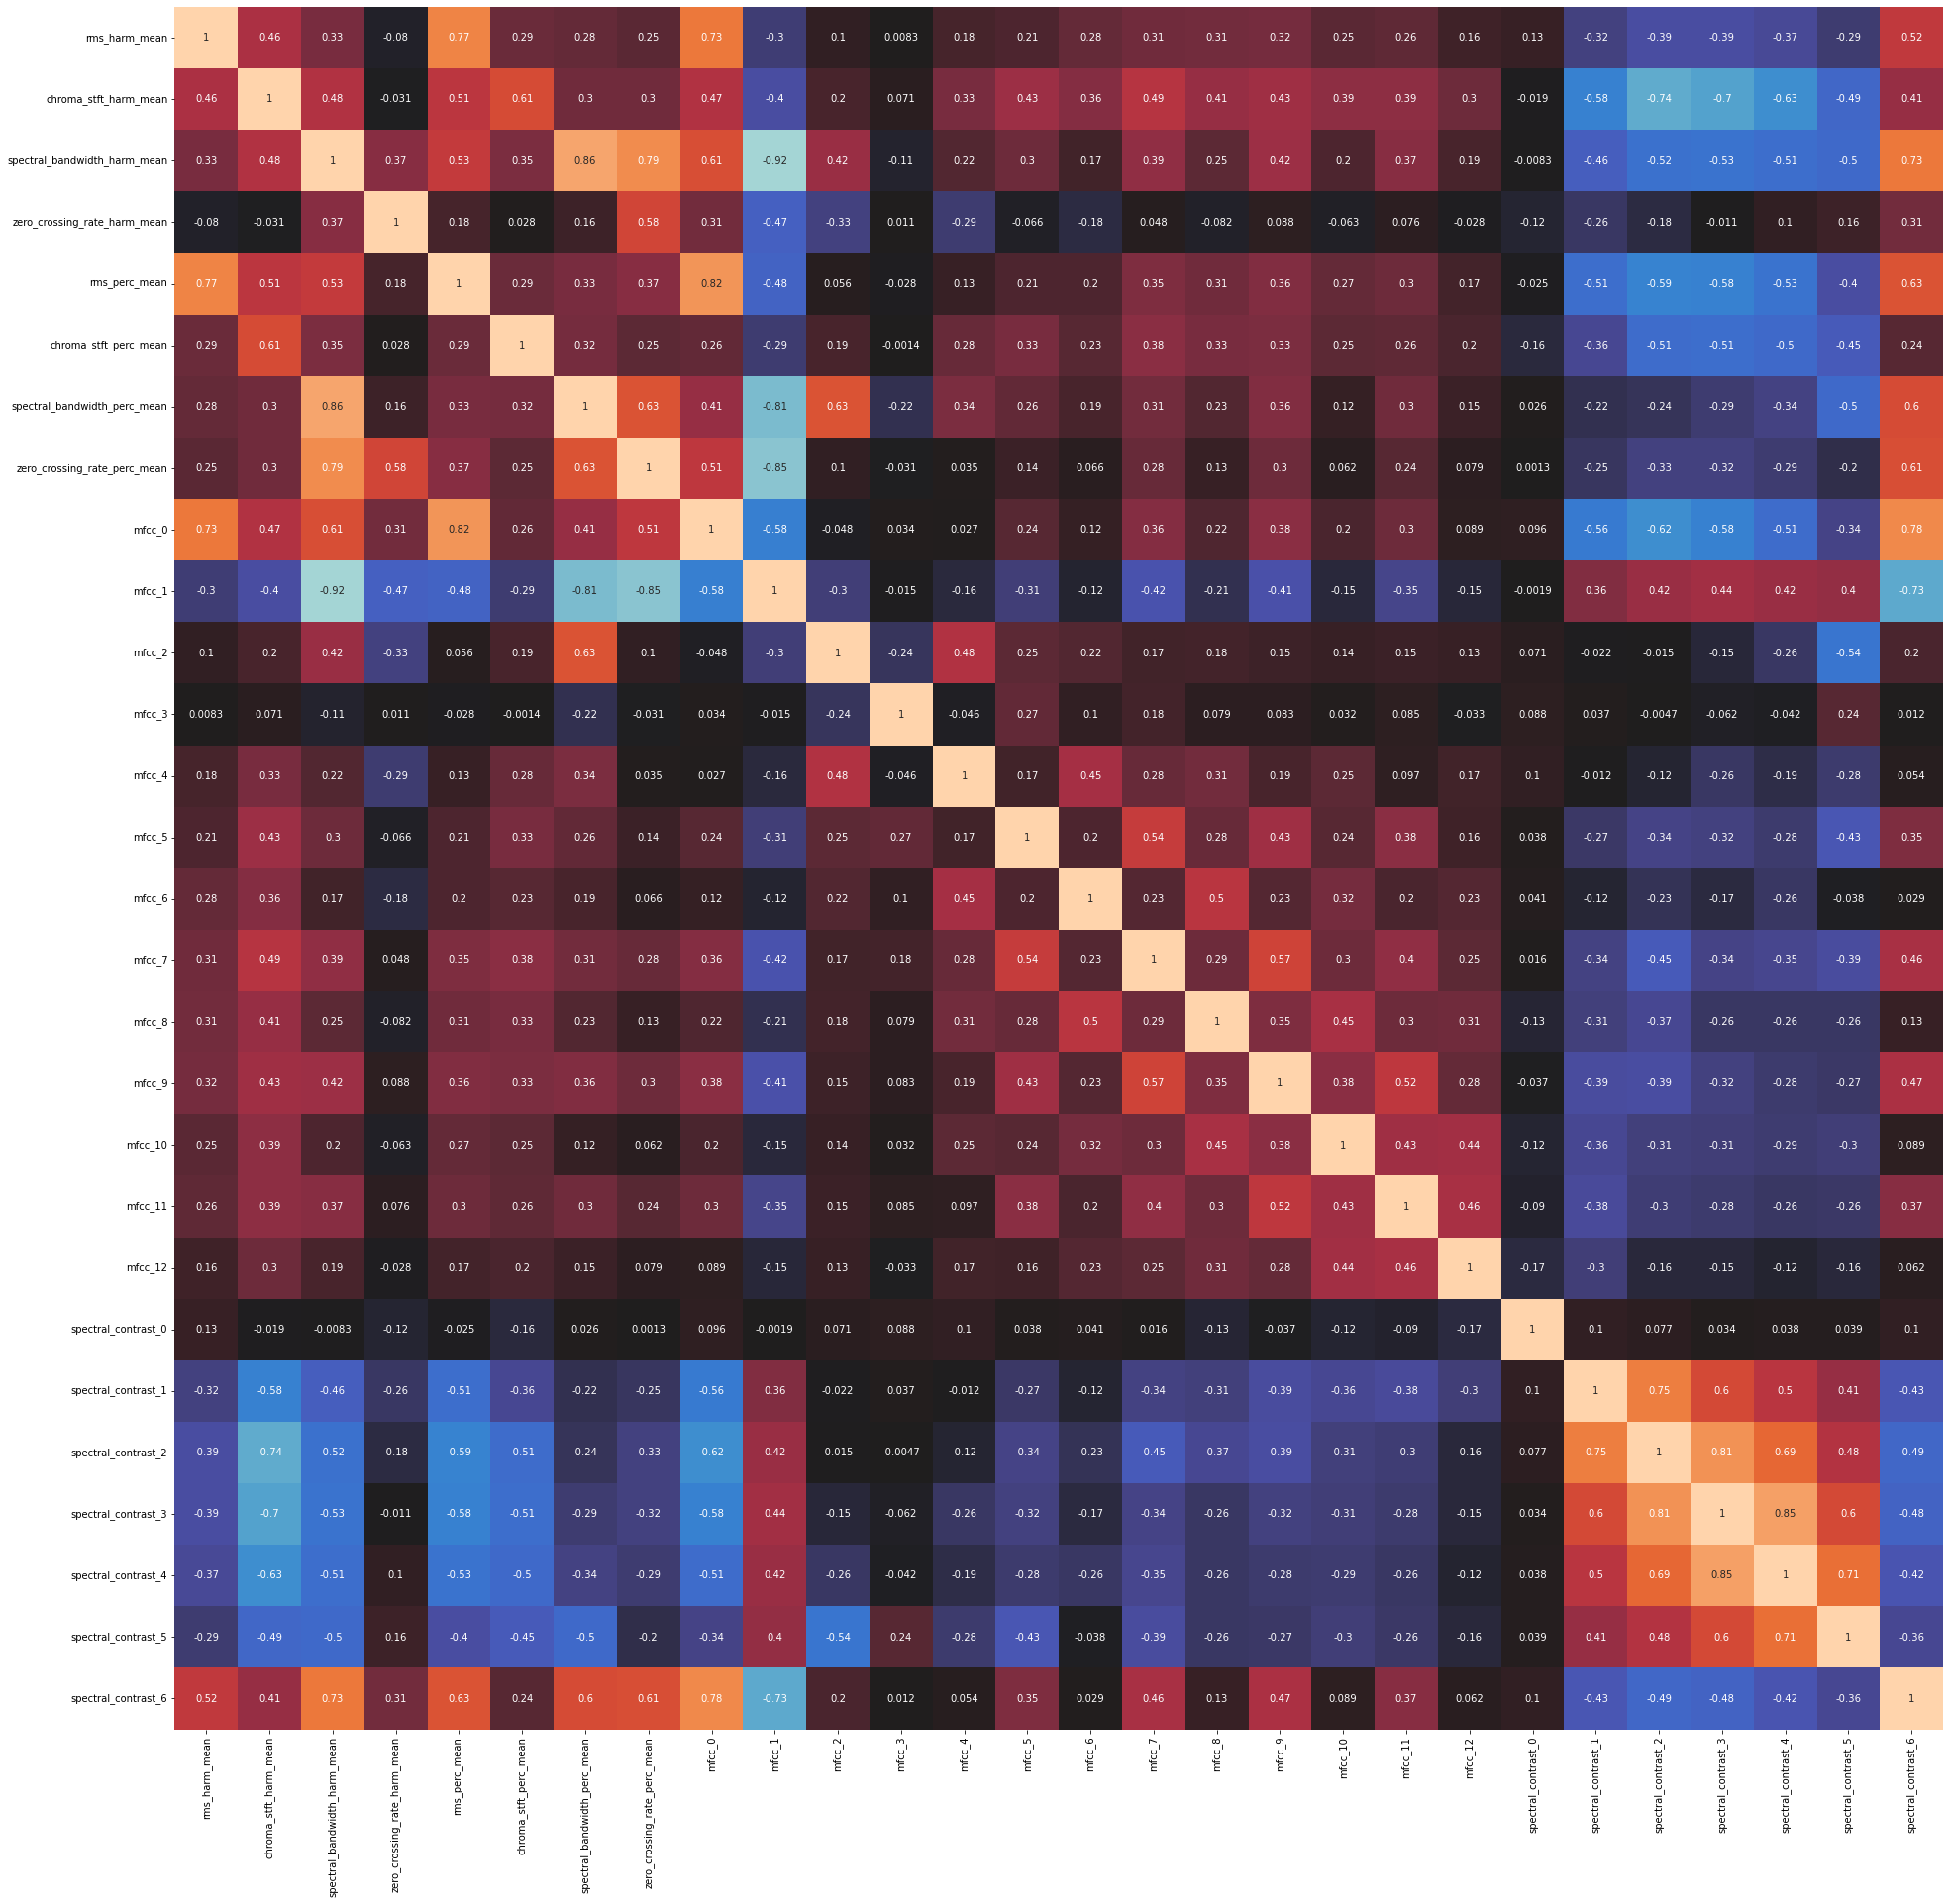

In [4]:
fig, ax = plt.subplots(figsize=(32,32))
import seaborn as sns

sns.heatmap(df.corr(), annot=True, center=0, ax=ax ,cbar=None);

In [5]:
drop_features=['genre','file_name']
#                'mfcc_19','mfcc_18','mfcc_17','mfcc_16','mfcc_15','mfcc_14', 'mfcc_13',
#  'spectral_centroid_harm_mean', 'spectral_rolloff_harm_mean', 'spectral_centroid_perc_mean', 
#        'spectral_rolloff_perc_mean',  'spectral_centroid_full_mean',
#         'spectral_bandwidth_full_mean', 'spectral_rolloff_full_mean',
#                'rms_full_mean', 'chroma_stft_full_mean', 'zero_crossing_rate_full_mean'  ] 

X = df.drop(drop_features,axis=1)
y=df['genre']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.columns

Index(['rms_harm_mean', 'chroma_stft_harm_mean',
       'spectral_bandwidth_harm_mean', 'zero_crossing_rate_harm_mean',
       'rms_perc_mean', 'chroma_stft_perc_mean',
       'spectral_bandwidth_perc_mean', 'zero_crossing_rate_perc_mean',
       'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6',
       'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12',
       'spectral_contrast_0', 'spectral_contrast_1', 'spectral_contrast_2',
       'spectral_contrast_3', 'spectral_contrast_4', 'spectral_contrast_5',
       'spectral_contrast_6'],
      dtype='object')

## Encoding Labels

In [6]:
encoder = LabelEncoder()
y_test_num = encoder.fit_transform(y_test)
y_train_num = encoder.fit_transform(y_train)



## XGBClassifier model without grid/pipe 
Will check feature importance:

In [8]:
# model = XGBClassifier( use_label_encoder=False, #tree_method='gpu_hist', gpu_id=0,
#                                           eval_metric=["error", "logloss"], gamma= 0.02, max_depth=6, 
#                                             n_estimators=800, n_jobs=-1, random_state=42)

# model.fit(X_train, y_train_num)

In [22]:
model = XGBClassifier()
model.load_model("../../models/XGB_model.json")

In [23]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)

## Quick Evaluaiton

In [24]:
print(model.score(X_test, y_test_num ))
print(classification_report(y_train_num, y_pred_train))
print('------------')
print(classification_report(y_test_num, y_pred_test))

0.9117330462863293
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1273
           1       1.00      1.00      1.00      1688
           2       1.00      1.00      1.00      1459
           3       1.00      1.00      1.00      1393
           4       1.00      1.00      1.00       804
           5       1.00      1.00      1.00      1467
           6       1.00      1.00      1.00      1599
           7       1.00      1.00      1.00      1077
           8       1.00      1.00      1.00      1221
           9       1.00      1.00      1.00       912
          10       1.00      1.00      1.00      1470
          11       1.00      1.00      1.00      1136
          12       1.00      1.00      1.00      1570
          13       1.00      1.00      1.00      1511

    accuracy                           1.00     18580
   macro avg       1.00      1.00      1.00     18580
weighted avg       1.00      1.00      1.00     18580

------

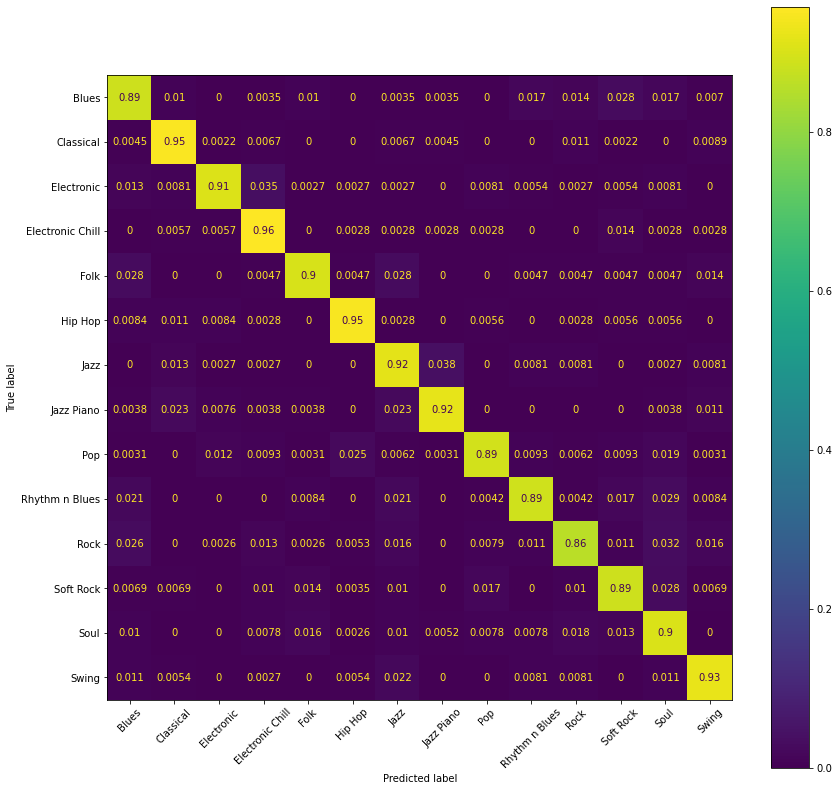

In [25]:
fig, ax = plt.subplots(figsize=(14,14))
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred_test, 
                                        display_labels=encoder.inverse_transform(gs_pipe.classes_), 
                                        ax=ax, normalize='true');
plt.xticks(rotation=45);

## Saving XGB Model

In [14]:
# model.save_model("../../models/XGB_model.json")


## Checking Feature Importance

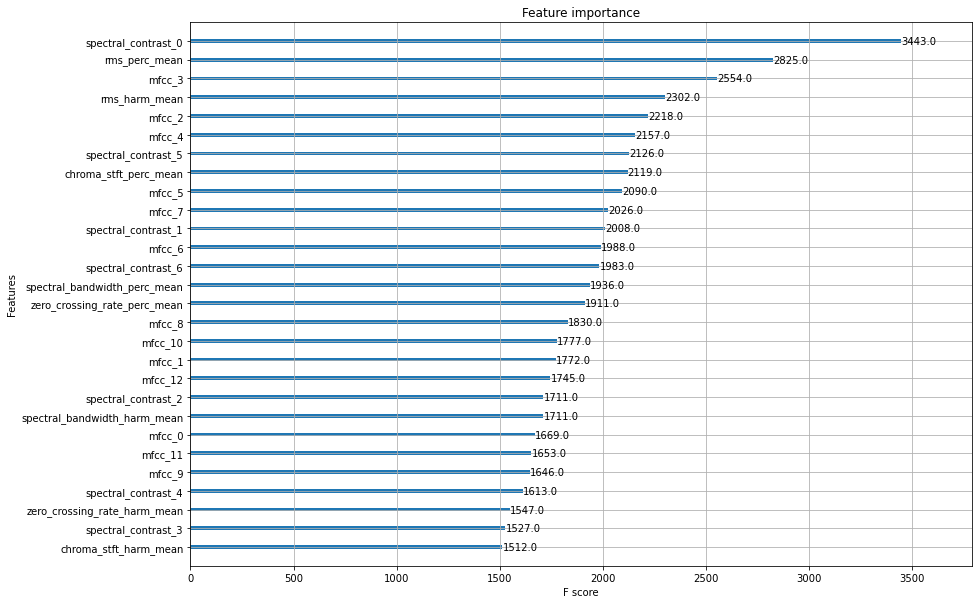

In [15]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(14,10))
plot_importance( model.get_booster(), ax=ax);



##  GRID to crossvalidate

In [16]:

XGB_pipeline = Pipeline([
                  ( "scaler", StandardScaler() ), 
                  ('boost', XGBClassifier( use_label_encoder=False,  #tree_method='gpu_hist', gpu_id=0,
                                          eval_metric=["error", "logloss"], gamma= 0.02, 
                                  max_depth=6, n_estimators=800, n_jobs=-1, random_state=42))
                 ])

#pipe_grid={'boost__max_depth':[5,6,7], 'boost__n_estimators':[100], 'boost__gamma':[0.1,0.125]}
pipe_grid={}
gs_pipe = GridSearchCV(estimator=XGB_pipeline, param_grid=pipe_grid,  cv=2, scoring='accuracy', verbose=3)

## Training

In [17]:
# gs_pipe.fit(X_train, y_train_num)

# gs_pipe.best_params_


In [18]:
with open('../../models/XGB_gs_pipe_new.joblib', 'rb') as f:
    gs_pipe = joblib.load(f)


## Predict

In [19]:
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

## Evaluation

In [20]:
print(gs_pipe.score(X_test, y_test_num ))
print(classification_report(y_train_num, y_pred_train))
print('------------')
print(classification_report(y_test_num, y_pred_test))

0.9095801937567277
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1273
           1       1.00      1.00      1.00      1688
           2       1.00      1.00      1.00      1459
           3       1.00      1.00      1.00      1393
           4       1.00      1.00      1.00       804
           5       1.00      1.00      1.00      1467
           6       1.00      1.00      1.00      1599
           7       1.00      1.00      1.00      1077
           8       1.00      1.00      1.00      1221
           9       1.00      1.00      1.00       912
          10       1.00      1.00      1.00      1470
          11       1.00      1.00      1.00      1136
          12       1.00      1.00      1.00      1570
          13       1.00      1.00      1.00      1511

    accuracy                           1.00     18580
   macro avg       1.00      1.00      1.00     18580
weighted avg       1.00      1.00      1.00     18580

------

## Saving/Loading

In [34]:
import joblib
with open('../../models/XGB_gs_pipe_new.joblib', 'wb') as f:
    joblib.dump(gs_pipe, f)

    

In [31]:
#with open('../../models/XGB_gs_pipe_harm_perc.joblib', 'rb') as f:
#    gs_pipe = joblib.load(f)